## 1. Load Library

In [1]:
!pip install -U efficientnet -qq

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import random_uniform, glorot_uniform
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
import os
import shutil
import json

from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Creating a function to streamline the Train data set   
def train_img_path(id_str):
    return os.path.join(r"/kaggle/input/histopathologic-cancer-detection/train", f"{id_str}.tif")

## 2. Exploratory Data Analysis

Image Shape = (96, 96, 3)


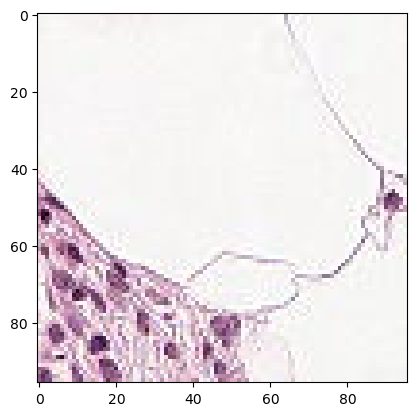

In [4]:
example_path = "/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif"
example_img = Image.open(example_path)
example_array = np.array(example_img)
print(f"Image Shape = {example_array.shape}")
plt.imshow(example_img)
plt.show()

In [5]:
train_labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_labels_df["filename"] = train_labels_df["id"].apply(train_img_path)
train_labels_df["label"] = train_labels_df["label"].astype(str)
train_labels_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


In [6]:
train_labels_df.shape

(220025, 3)

In [7]:
train_labels_df["label"][0]

'0'

In [8]:
set(train_labels_df['label'])

{'0', '1'}

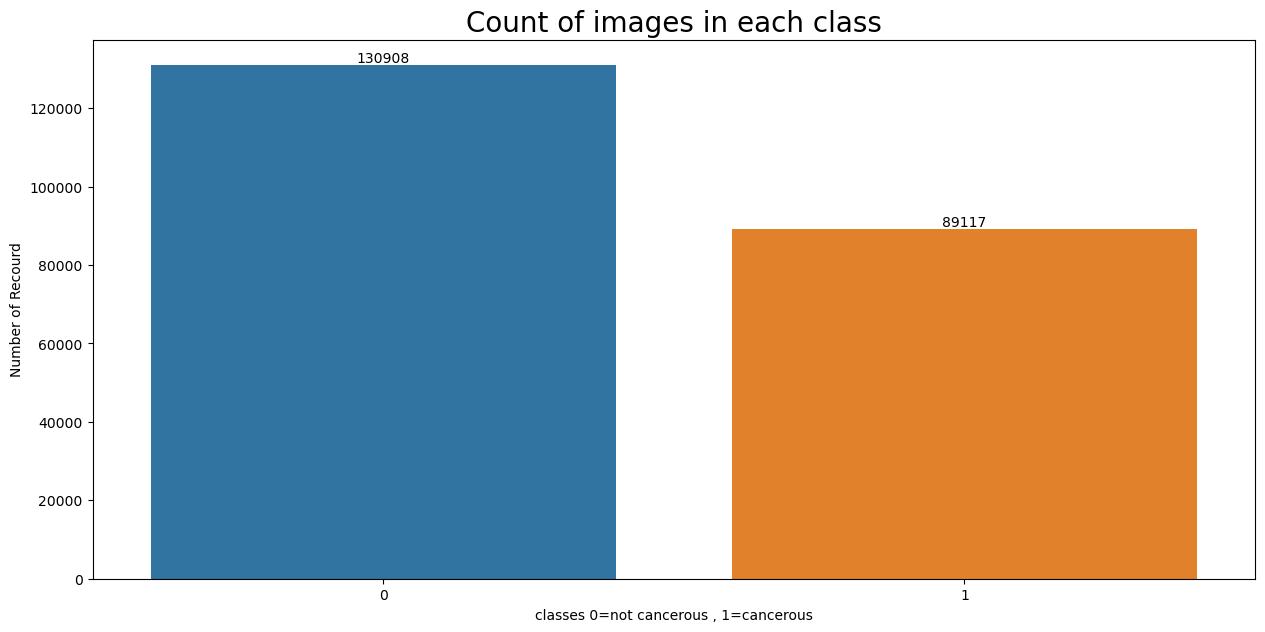

In [12]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_labels_df , x=train_labels_df['label'])

plt.xlabel('classes 0=not cancerous , 1=cancerous')
plt.ylabel('Number of Recourd')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

We have 220,025 images in the train data set with 2 unique labels. 0 for not cancerous and 1 for cancerous tissues.

## Label 0 = Not-Cancerous
## Label 1 = Cancerous

In [13]:
train_labels_df['label'].value_counts(normalize = True)

0    0.594969
1    0.405031
Name: label, dtype: float64

In [14]:
sample_data = np.empty((100, 96, 96, 3), dtype=np.uint8)
sample_labels = np.empty(100, dtype=np.int8)
for i in range(len(train_labels_df))[:100]:
    img_path = train_img_path(train_labels_df['id'][i])
    img = Image.open(img_path)
    sample_data[i] = np.array(img)
    sample_labels[i] = train_labels_df['label'][i]

Non-Cancerous Images


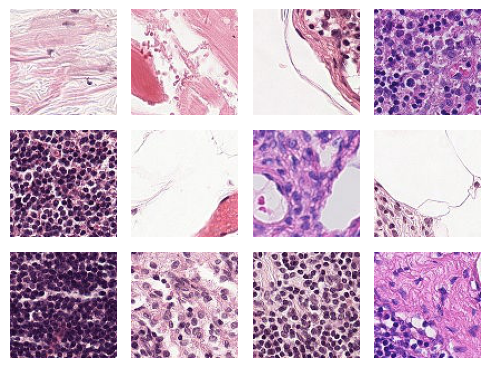

In [15]:
print("Non-Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 0].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 0][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

Cancerous Images


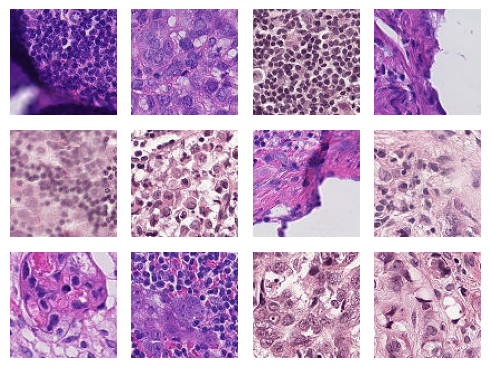

In [16]:
print("Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 1].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 1][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

## 3. Model Designing

In this part we will perform various steps required to properly create the Resnet 50 model. We will load the data from the disk, specify train and validation data generators while creating test generator for the final submission.

We will then create a modified Resnet 50 suited for this task.

In [17]:
test_path = "/kaggle/input/histopathologic-cancer-detection/test"
test_ids = [filename[:-4] for filename in os.listdir(test_path)]
test_filenames = [os.path.join(test_path, filename) for filename in os.listdir(test_path)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filename"] = test_filenames

In [18]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

In [19]:
train_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "training",
    validate_filenames = False,
    seed = 10
)

validation_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe=train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size=(96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "validation",
    validate_filenames = False,
    seed = 10
)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.


In [20]:
test_generator = datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "filename",
    y_col = None,
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 64,
    shuffle = False,
    class_mode = None,
    validate_filenames = False,
    seed = 10
)

Found 57458 non-validated image filenames.


In [21]:
train_steps = 176020//32  # 8000 images for training
val_steps = 44005//32  

Now we will create Resnet50 model.

It is to be noted that we can actually use transfer learning and import the model and its trained parameters based on imagenet from the tensorflow API. But for this project we will create a modified model.

There will be two types of blocks, identity blocks where input and output dimension remains the same, and convolutional blocks where input and output dimensions are allowed to be changed. In both blocks we will use strong skip connections.

After convolutional we will use fully collected layers with output being a dense Sigmoid unit.

In the end we will have a Resnet model with 50 layers.

In [22]:
def identity_block(X, f, filters, training=True, initializer = random_uniform):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = tfl.Activation('relu')(X)
    
    ## Set the padding = 'same'
    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training)
    X = tfl.Activation('relu')(X)


    ## Set the padding = 'valid'
    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', kernel_initializer = initializer(seed = 0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)

    return X


In [23]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer = glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X)
    
    X = tfl.Conv2D(filters = F2, kernel_size = (f,f), strides = 1, padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X) 

    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = 1, padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training) 

    X_shortcut = tfl.Conv2D(filters = F3, kernel_size = (1,1), strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    
    return X

In [24]:
def ResNet50(input_shape = (96, 96, 3)):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = tfl.Input(input_shape)

    
    # Zero-Padding
    X = tfl.ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = tfl.Conv2D(96, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tfl.Activation('relu')(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    # Use the instructions above in order to implement all of the Stages below
    # Make sure you don't miss adding any required parameter
    
    ## Stage 3 (≈4 lines)
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    
    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D()(X)"
    X = tfl.AveragePooling2D(pool_size = (2,2))(X)
    

    # output layer
    X = tfl.Flatten()(X)
    X = tfl.Dense(1, kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [25]:
model = ResNet50(input_shape = (96, 96, 3))
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 96)   14208       ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 96)  384         ['conv2d[0][0]']                 
 alization)                                                                                   

Above is the model summary. We have 23,551,681 trainable parameters. If we use more deeper network number of parameters will increase with possible increase in Accuracy or AUC. But for this model we will use resnet 50 only.

## 4. Model Deployment

In [26]:
from IPython.display import Image
Image(url="https://wisdomml.in/wp-content/uploads/2023/03/resnet_bannner.png")

In this part we will use the model created and fit the model with Adam optimizer and loss as binary cross entropy. We have used from logits = True for better accuracy. If reader wants to avoid it they can modify the last output layer in Resnet50 above and make the Activation function as sigmoid instead of linear.

# Create F1 - Score Metric for Classification Evaluation 

In [32]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

In [33]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy', tf.keras.metrics.AUC(), f1_score])

In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = validation_generator,
    validation_steps = val_steps,
    epochs = 10
)

Epoch 1/10
5500/5500 [==============================] - 1554s 275ms/step - loss: 0.3688 - accuracy: 0.8361 - auc_1: 0.8506 - f1_score: 0.7734 - val_loss: 0.3142 - val_accuracy: 0.8547 - val_auc_1: 0.8657 - val_f1_score: 0.7985
Epoch 2/10
5500/5500 [==============================] - 479s 87ms/step - loss: 0.2717 - accuracy: 0.8840 - auc_1: 0.8967 - f1_score: 0.8451 - val_loss: 0.2460 - val_accuracy: 0.9042 - val_auc_1: 0.9191 - val_f1_score: 0.8765
Epoch 3/10
5500/5500 [==============================] - 405s 74ms/step - loss: 0.2149 - accuracy: 0.9120 - auc_1: 0.9225 - f1_score: 0.8839 - val_loss: 0.2280 - val_accuracy: 0.9014 - val_auc_1: 0.9058 - val_f1_score: 0.8653
Epoch 4/10
5500/5500 [==============================] - 392s 71ms/step - loss: 0.1834 - accuracy: 0.9263 - auc_1: 0.9348 - f1_score: 0.9034 - val_loss: 0.1860 - val_accuracy: 0.9256 - val_auc_1: 0.9324 - val_f1_score: 0.9001
Epoch 5/10
5500/5500 [==============================] - 387s 70ms/step - loss: 0.1627 - accuracy: 

In [35]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

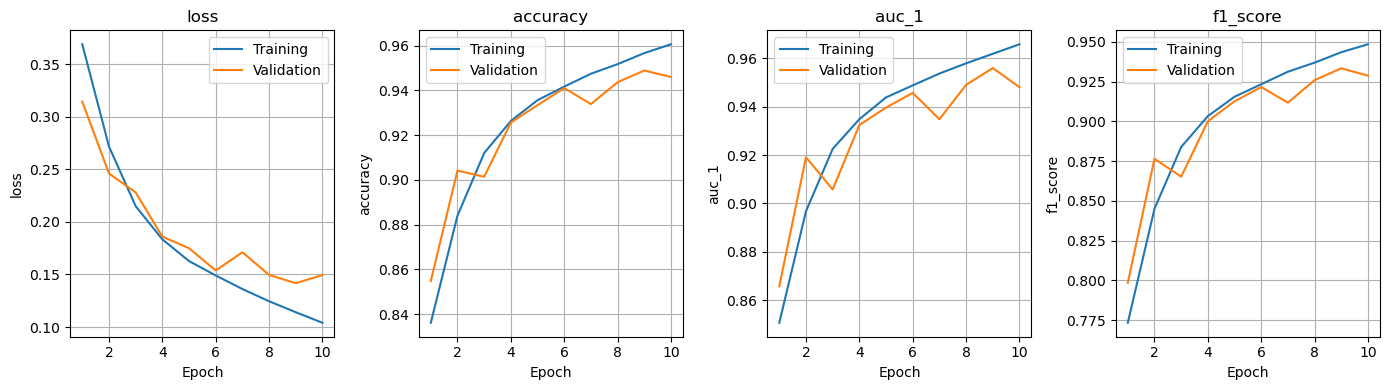

In [36]:
history_modelrestnet = merge_history([history])
vis_training(history_modelrestnet)

It takes around 2 hours to train the model with 10 epochs and Kaggle P100 GPU. We can increase the number of epochs but only Training loss decrease for some time after 10 epochs with little change in validation loss and accuracy. In fact we can see from above that after 6th Epoch Validation Accruacy has not changed much.

So, it will not be efficient to train with more epochs but readers can do it if they have resources and time for this.

## 5. Model Evaluation

Above we have used a threshold of 0.5 which is just assumed and is totally not correct. There was no decision boundary given with the dataset so we cant use above metrics to test the performance of the model.

In order to test the model performance we need to create a submission and get the AUC we will obtain from such submission.

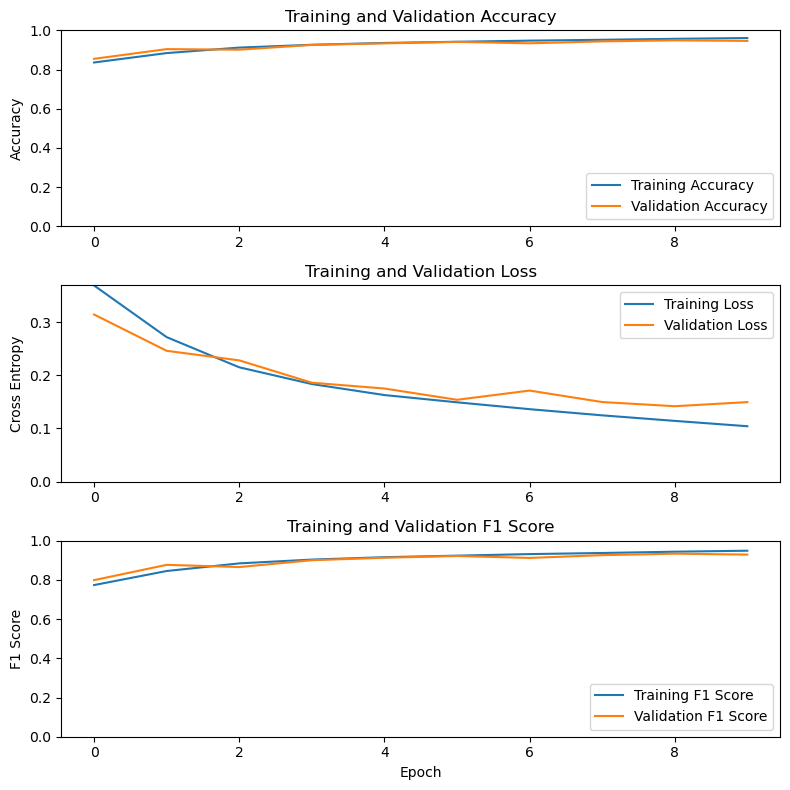

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

F1_score = history.history['f1_score']
F1_score_valid = history.history['val_f1_score']

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')

# Plot Training and Validation F1 Score
plt.subplot(3, 1, 3)
plt.plot(F1_score, label='Training F1 Score')
plt.plot(F1_score_valid, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# Model 2 --> EfficientNetB0

In [38]:
from IPython.display import Image
Image(url="https://media.licdn.com/dms/image/D4E12AQHL32j_wE3JTw/article-cover_image-shrink_720_1280/0/1669236519664?e=1727308800&v=beta&t=BM4KMl52c-TXWz0C-SCD_MbHo1_rdXaC6UWRhTNqZqo")

In [39]:
base_model_EfficientNetB0 = efn.EfficientNetB0(input_shape=(96,96,3), include_top=False, weights='imagenet')

model_EfficientNetB0 = Sequential([
    base_model_EfficientNetB0,
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model_EfficientNetB0.summary()

16804768/16804768 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 3, 3, 1280)       4049564   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               2949376   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0 

In [40]:
model_EfficientNetB0.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy', tf.keras.metrics.AUC(), f1_score])

In [41]:
h1 = model_EfficientNetB0.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = validation_generator,
    validation_steps = val_steps,
    epochs = 10
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-08-02 11:01:30.343346: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5500/5500 [==============================] - 551s 92ms/step - loss: 0.2337 - accuracy: 0.9133 - auc_2: 0.9643 - f1_score: 0.8897 - val_loss: 0.1806 - val_accuracy: 0.9323 - val_auc_2: 0.9806 - val_f1_score: 0.9092
Epoch 2/10
5500/5500 [==============================] - 403s 73ms/step - loss: 0.1649 - accuracy: 0.9422 - auc_2: 0.9813 - f1_score: 0.9256 - val_loss: 0.1440 - val_accuracy: 0.9469 - val_auc_2: 0.9853 - val_f1_score: 0.9312
Epoch 3/10
5500/5500 [==============================] - 410s 75ms/step - loss: 0.1371 - accuracy: 0.9534 - auc_2: 0.9865 - f1_score: 0.9396 - val_loss: 0.1294 - val_accuracy: 0.9523 - val_auc_2: 0.9890 - val_f1_score: 0.9398
Epoch 4/10
5500/5500 [==============================] - 392s 71ms/step - loss: 0.1188 - accuracy: 0.9602 - auc_2: 0.9895 - f1_score: 0.9484 - val_loss: 0.1151 - val_accuracy: 0.9610 - val_auc_2: 0.9900 - val_f1_score: 0.9483
Epoch 5/10
5500/5500 [==============================] - 391s 71ms/step - loss: 0.1048 - accuracy: 0.9652 - auc_

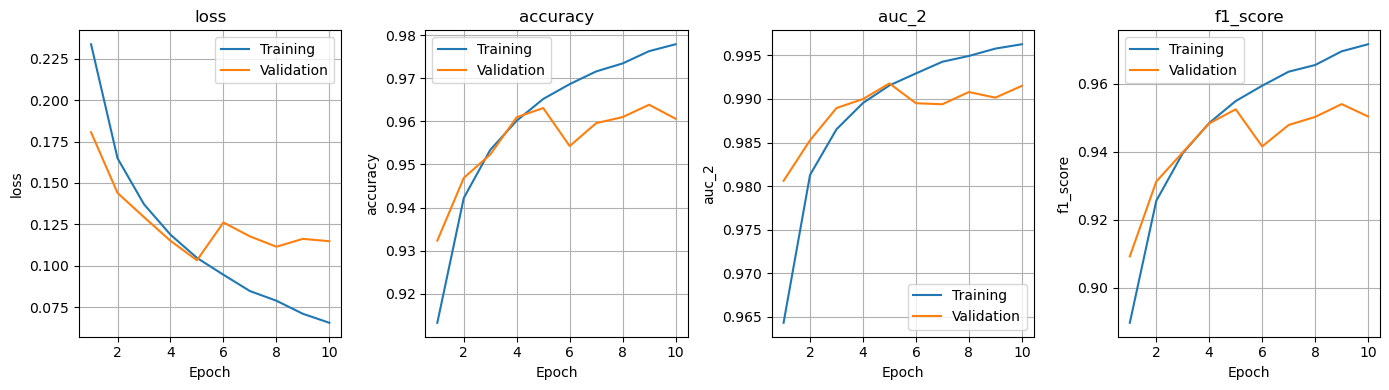

In [42]:
history_model_B0 = merge_history([h1])
vis_training(history_model_B0)

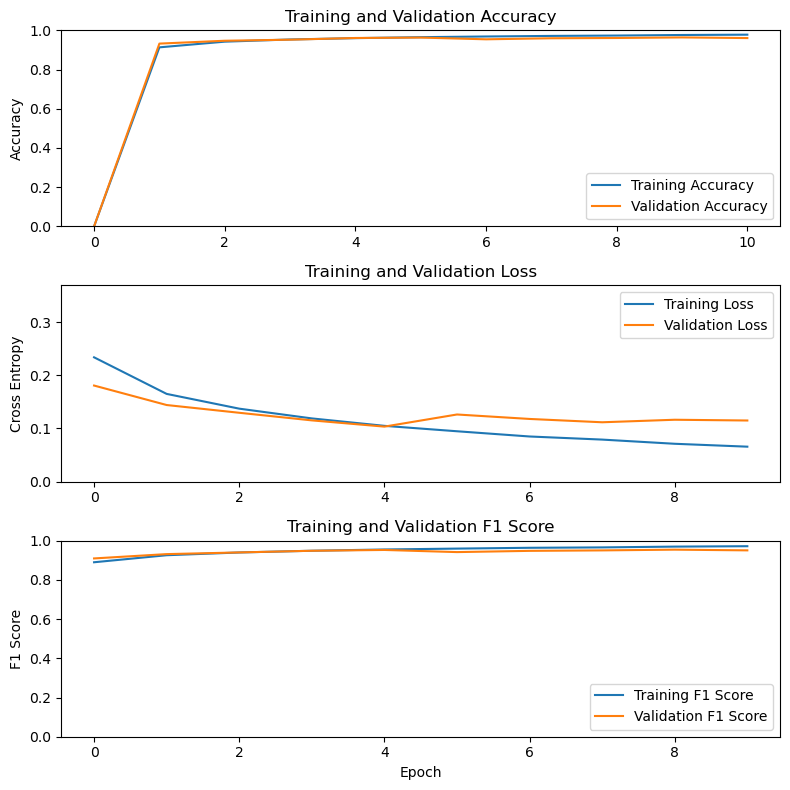

In [49]:
acc_B0 = [0.] + h1.history['accuracy']
val_acc_B0 = [0.] + h1.history['val_accuracy']

loss_B0 = h1.history['loss']
val_loss_B0 = h1.history['val_loss']

F1_score_B0 = h1.history['f1_score']
F1_score_valid_B0 = h1.history['val_f1_score']

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(3, 1, 1)
plt.plot(acc_B0, label='Training Accuracy')
plt.plot(val_acc_B0, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(3, 1, 2)
plt.plot(loss_B0, label='Training Loss')
plt.plot(val_loss_B0, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')

# Plot Training and Validation F1 Score
plt.subplot(3, 1, 3)
plt.plot(F1_score_B0, label='Training F1 Score')
plt.plot(F1_score_valid_B0, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# Model 3 --> Xception

In [50]:
from IPython.display import Image
Image(url="https://www.ismrm.org/21/program-files/TeaserSlides/abstracts/images/1945/ISMRM2021-001945_Fig6.png")

In [51]:
img_shape=(96, 96,3)
base_model_Xception = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')
    
model_Xception = Sequential([
    base_model_Xception,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(1, activation= 'sigmoid')
])

model_Xception.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy', tf.keras.metrics.AUC(), f1_score])

model_Xception.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                       

In [52]:
h2 = model_Xception.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = validation_generator,
    validation_steps = val_steps,
    epochs = 10
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5500/5500 [==============================] - 462s 79ms/step - loss: 0.2336 - accuracy: 0.9112 - auc_3: 0.9643 - f1_score: 0.8851 - val_loss: 0.2607 - val_accuracy: 0.8868 - val_auc_3: 0.9777 - val_f1_score: 0.8698
Epoch 2/10
5500/5500 [==============================] - 427s 78ms/step - loss: 0.1538 - accuracy: 0.9447 - auc_3: 0.9835 - f1_score: 0.9289 - val_loss: 0.3021 - val_accuracy: 0.8732 - val_auc_3: 0.9806 - val_f1_score: 0.8080
Epoch 3/10
5500/5500 [==============================] - 427s 78ms/step - loss: 0.1233 - accuracy: 0.9562 - auc_3: 0.9890 - f1_score: 0.9431 - val_loss: 0.1954 - val_accuracy: 0.9200 - val_auc_3: 0.9835 - val_f1_score: 0.9033
Epoch 4/10
5500/5500 [==============================] - 428s 78ms/step - loss: 0.1047 - accuracy: 0.9636 - auc_3: 0.9919 - f1_score: 0.9531 - val_loss: 0.1429 - val_accuracy: 0.9493 - val_auc_3: 0.9883 - val_f1_score: 0.9354
Epoch 5/10
5500/5500 [==============================] - 428s 78ms/step - loss: 0.0855 - accuracy: 0.9704 - auc_

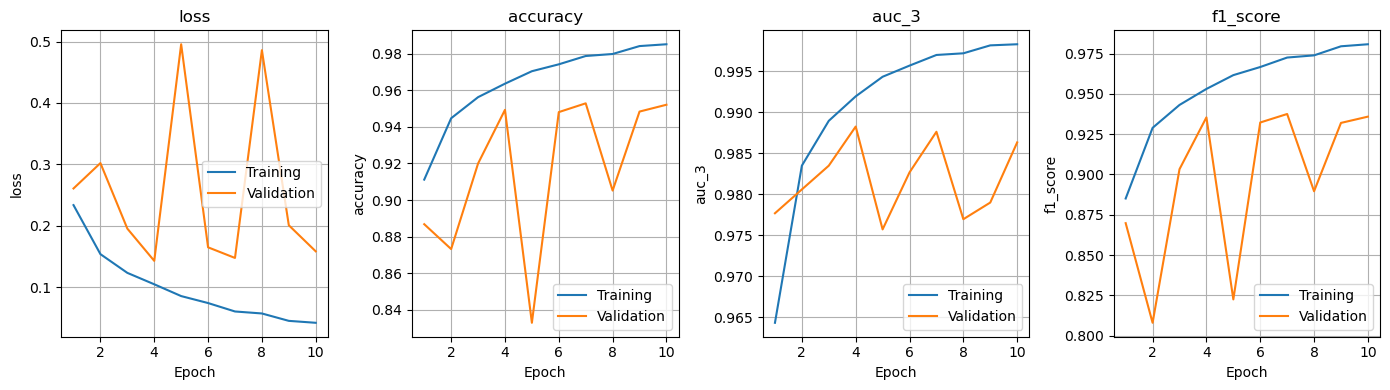

In [53]:
history_model_Xception = merge_history([h2])
vis_training(history_model_Xception)

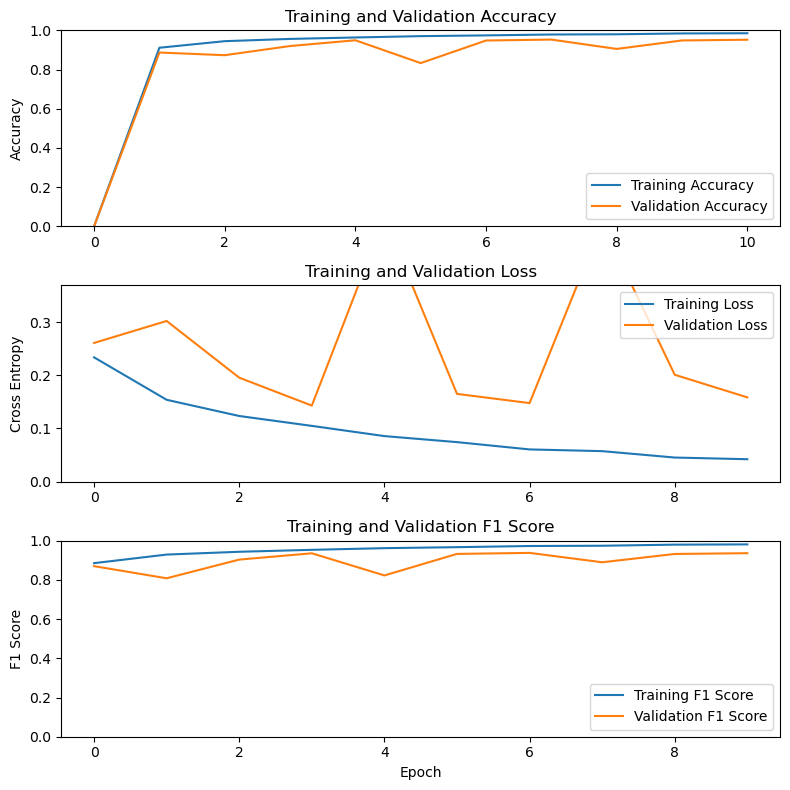

In [54]:
acc_Xception = [0.] + h2.history['accuracy']
val_acc_Xception = [0.] + h2.history['val_accuracy']

loss_Xception = h2.history['loss']
val_loss_Xception = h2.history['val_loss']

F1_score_Xception = h2.history['f1_score']
F1_score_valid_Xception = h2.history['val_f1_score']

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(3, 1, 1)
plt.plot(acc_Xception, label='Training Accuracy')
plt.plot(val_acc_Xception, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(3, 1, 2)
plt.plot(loss_Xception, label='Training Loss')
plt.plot(val_loss_Xception, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')

# Plot Training and Validation F1 Score
plt.subplot(3, 1, 3)
plt.plot(F1_score_Xception, label='Training F1 Score')
plt.plot(F1_score_valid_Xception, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# Model 4 --> Vision Transformer (ViT)

In [55]:
from IPython.display import Image
Image(url="https://cdn-lfs.huggingface.co/datasets/huggingface/documentation-images/142f1b9c07445fbc30f72e4e8e629a9cf11488a78ca6babc8bdb49c11e42b672?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27vit_architecture.jpg%3B+filename%3D%22vit_architecture.jpg%22%3B&response-content-type=image%2Fjpeg&Expires=1721966721&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMTk2NjcyMX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9kYXRhc2V0cy9odWdnaW5nZmFjZS9kb2N1bWVudGF0aW9uLWltYWdlcy8xNDJmMWI5YzA3NDQ1ZmJjMzBmNzJlNGU4ZTYyOWE5Y2YxMTQ4OGE3OGNhNmJhYmM4YmRiNDljMTFlNDJiNjcyP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=m9lRPCippy3Q01FqLAaM-6Y0BHJAQtDdNCNBDWQ3iX78TSKQC-5dxBaFaWBZ9uAmHjNQBpgzJeW9rlKrB9lQDMRPo8-%7Efl9g7djOVm%7EkE85ZxX3N8s8DZ664DqQ6pxt2l5mPu8AYqEU5ncNi2GotdmMH3zHxenmSM2gr-rI9xges0maUrhvu0WDC44MA0W2pH7Mrsg3GicEqM9gL0Qmr8rs5f%7EVFhVZKz8EtVocO32lsp0L%7Emia2JnGXiBQVwFcWdT%7EUBMpss1nzJSAwsrx8wAuQ%7E9g82ASAiEq6Tp1sy-onzbolXqh41pskL1YXZw8A95Yiyypv2mgzQ661MxTeeg__&Key-Pair-Id=K3ESJI6DHPFC7")

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [57]:
class VisionTransformer(Model):
    def __init__(self, img_size, patch_size, num_classes, embed_dim=256, num_heads=4, num_layers=4, mlp_dim=512):
        super(VisionTransformer, self).__init__()
        
        self.patch_size = patch_size
        self.img_size = img_size
        self.num_patches = (img_size // patch_size) ** 2

        self.input_layer = Input(shape=(img_size, img_size, 3))
        
        self.patch_embedding = tf.keras.layers.Conv2D(filters=embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')
        
        self.position_embedding = Embedding(input_dim=self.num_patches, output_dim=embed_dim)
        
        self.transformer_layers = [tf.keras.layers.LayerNormalization(epsilon=1e-6) for _ in range(num_layers)]
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.mlp = tf.keras.Sequential([
            Dense(mlp_dim, activation='relu'),
            Dense(embed_dim)
        ])
        
        self.flatten = Flatten()
        self.output_layer = Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        x = self.patch_embedding(inputs)
        x = tf.reshape(x, (-1, self.num_patches, x.shape[-1]))

        x += self.position_embedding(tf.range(start=0, limit=self.num_patches))
        
        for layer in self.transformer_layers:
            x = layer(x)
            x = self.multi_head_attention(x, x)
            x = Dropout(0.1)(x)
            
            # MLP
            x = self.mlp(x)
        
        x = self.flatten(x)
        x = self.output_layer(x)
        return x


img_size = 96 
patch_size = 16
num_classes = 1


vit_model = VisionTransformer(img_size=img_size, patch_size=patch_size, num_classes=num_classes)
vit_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(), f1_score])

In [58]:
vit_h = vit_model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = validation_generator,
    validation_steps = val_steps,
    epochs = 10
)

Epoch 1/10
5500/5500 [==============================] - 319s 57ms/step - loss: 0.6752 - accuracy: 0.5910 - auc_4: 0.5271 - f1_score: 0.0609 - val_loss: 0.6474 - val_accuracy: 0.5961 - val_auc_4: 0.6519 - val_f1_score: 0.0000e+00
Epoch 2/10
5500/5500 [==============================] - 310s 56ms/step - loss: 0.6711 - accuracy: 0.5931 - auc_4: 0.5349 - f1_score: 0.0356 - val_loss: 0.6219 - val_accuracy: 0.5961 - val_auc_4: 0.6368 - val_f1_score: 0.0000e+00
Epoch 3/10
5500/5500 [==============================] - 313s 57ms/step - loss: 0.6723 - accuracy: 0.5944 - auc_4: 0.5182 - f1_score: 0.0065 - val_loss: 0.6747 - val_accuracy: 0.5961 - val_auc_4: 0.5000 - val_f1_score: 0.0000e+00
Epoch 4/10
5500/5500 [==============================] - 314s 57ms/step - loss: 0.6755 - accuracy: 0.5943 - auc_4: 0.5016 - f1_score: 0.0026 - val_loss: 0.6751 - val_accuracy: 0.5962 - val_auc_4: 0.5000 - val_f1_score: 0.0000e+00
Epoch 5/10
5500/5500 [==============================] - 314s 57ms/step - loss: 0.675

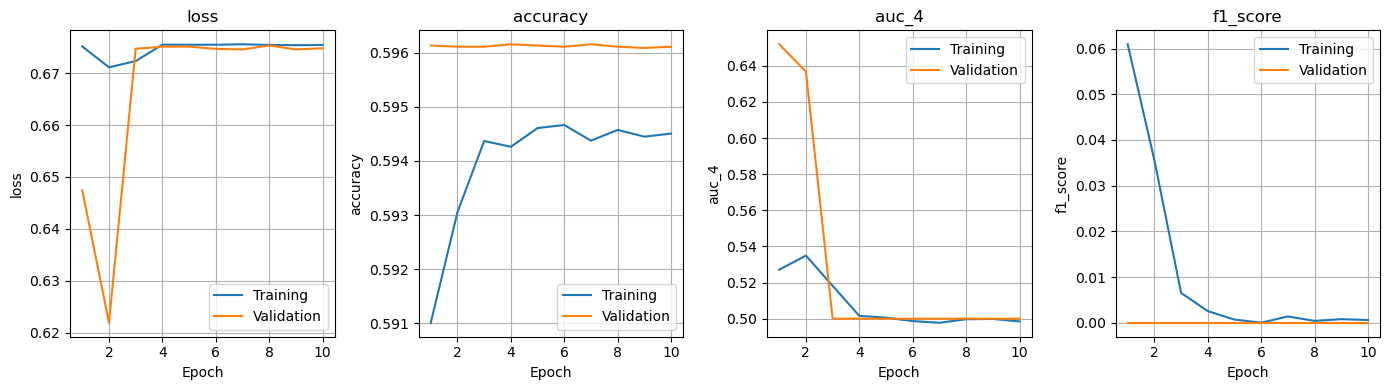

In [59]:
history_model_ViT = merge_history([vit_h])
vis_training(history_model_ViT)

# -----------------------------------------------------------------------

# Vision Transformer (Hugging Face)

In [ ]:
import torch
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, TrainingArguments, Trainer, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
from datasets import load_metric

In [ ]:
new_data = train_labels_df.drop(columns='id', axis=1)
new_data = new_data[['filename', 'label']]
new_data['label'] = new_data['label'].astype('int')
new_data.head(5)

In [55]:
new_data.shape

(220025, 2)

In [58]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_extractor, transform=None):
        self.dataframe = dataframe
        self.feature_extractor = feature_extractor
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        encoding = self.feature_extractor(images=image, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['label'] = torch.tensor(label, dtype=torch.float32)

        return item

# Load data
train_labels_df = new_data.iloc[:500]
val_labels_df = new_data.iloc[100:]

# Initialize feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Transformations
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

# Create datasets
train_dataset = CustomDataset(train_labels_df, feature_extractor, transform=transform)
val_dataset = CustomDataset(val_labels_df, feature_extractor, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
num_labels = 1  # Binary classification
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_labels)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./kaggle/working/result',  # Ensure this is a valid path
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_steps=10,
    evaluation_strategy="steps"
)

# Load accuracy metric
accuracy_metric = load_metric("accuracy")

# Define compute_metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=p.label_ids)

# Define data collator
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([item['pixel_values'] for item in batch]),
        'labels': torch.tensor([item['label'] for item in batch])
    }

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss


In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)